<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-das-bibliotecas" data-toc-modified-id="Download-das-bibliotecas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download das bibliotecas</a></span></li><li><span><a href="#Construção-do-Modelo" data-toc-modified-id="Construção-do-Modelo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construção do Modelo</a></span></li><li><span><a href="#Otimização-dos-Parâmetros" data-toc-modified-id="Otimização-dos-Parâmetros-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Otimização dos Parâmetros</a></span></li><li><span><a href="#Variação-dos-parametros" data-toc-modified-id="Variação-dos-parametros-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Variação dos parametros</a></span></li></ul></div>

## Download das bibliotecas

In [1]:
using Pkg
Pkg.activate("..")
Pkg.status()

Activating environment at `D:\modelo-covid19\Project.toml`
    Status `D:\modelo-covid19\Project.toml`
  [aae7a2af] DiffEqFlux v1.9.0
  [1130ab10] DiffEqParamEstim v1.14.0
  [41bf760c] DiffEqSensitivity v6.13.0
  [ef61062a] DiffEqUncertainty v1.4.1
  [0c46a032] DifferentialEquations v6.13.0
  [587475ba] Flux v0.10.4
  [429524aa] Optim v0.20.6
  [1dea7af3] OrdinaryDiffEq v5.35.5
  [65888b18] ParameterizedFunctions v5.3.0
  [438e738f] PyCall v1.91.4
  [d330b81b] PyPlot v2.9.0
  [8a4e6c94] QuasiMonteCarlo v0.2.0
  [e88e6eb3] Zygote v0.4.19


In [2]:
include("../src/dados.jl");

In [3]:
include("../src/models.jl");

In [4]:
include("../src/graphs.jl");

In [12]:
include("../src/parametrization.jl");

In [6]:
include("../src/optimization.jl");

## Construção do Modelo

In [13]:
Ts = 0.0:1.0:float(n_pts)
sol = model(params_rio_base, CI_Rio, Ts);

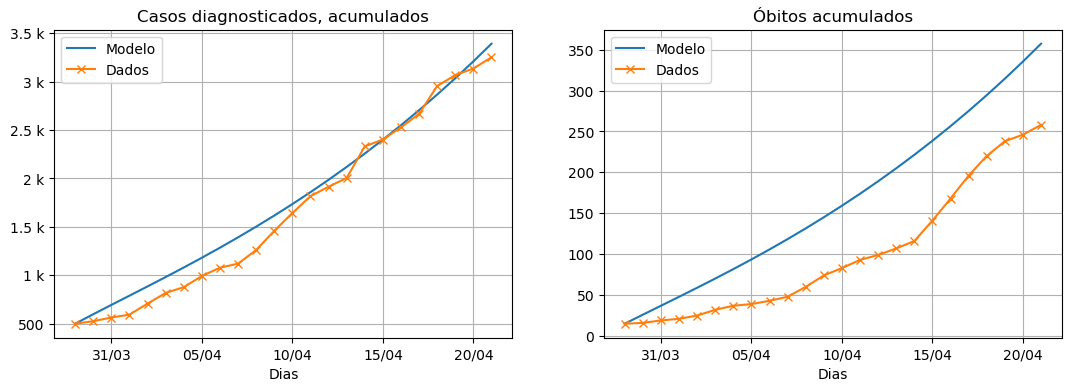

In [14]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_dados = "x-")
end

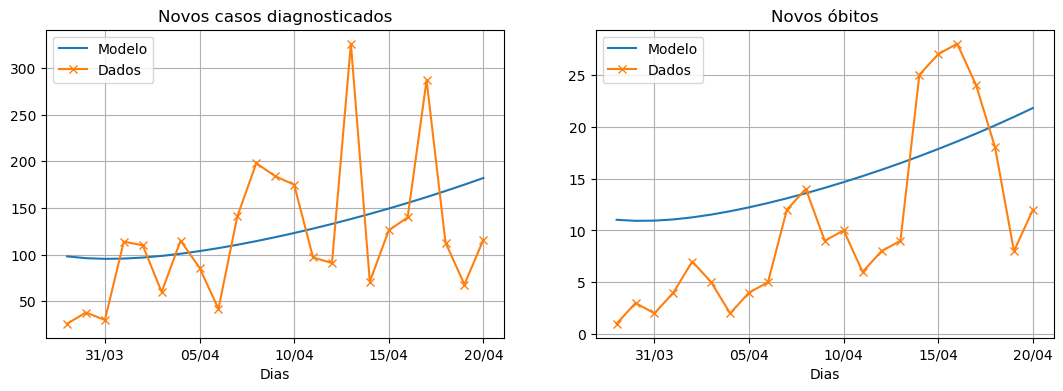

In [15]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Novos casos diagnosticados")
axs[2].set_title("Novos óbitos")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_daily(serie, data,real_data = true, ax = ax)
end

## Otimização dos Parâmetros

In [16]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 75.36444498598763
          Sintomática   = 1180.709638113805
    
Taxa de contágio    = 2.2552352348167335
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.94
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [17]:
loss_obj(p_start)

373081.2634298075

In [35]:
res = DiffEqFlux.sciml_train(loss_adjoint, p_start, Fminbox(LBFGS()),
    lower_bounds=[0.0, 0.01, 0.4, 0.92, 0, 0.2, 2], upper_bounds=[1e-6, 0.2, 0.7, 0.94, 0.4, 0.6, 50],
    cb = cb)

372918.96181714494

333133.5119153937

332394.3637031037

331724.7202570591

330444.51459917333

330426.4161221425

330487.38960904314

330443.1458468059

330436.4159230221

330481.66241173283

330491.90621667594

330455.59618691116

330433.87211951014

330437.3660318073

330435.2924092236

330434.43733908667

330437.8888942389

330443.6959969925

330448.796753771

330448.80186361977

330448.93766374374

330448.95677325455

330448.9636298063

330449.0322197159

330449.03296081664

330449.03073344135

330449.03296081664

330448.7900269182

330448.5276833523

330445.30463690154

330382.03047776787

330381.5737687211

330376.64043252333

330374.01887695247

330371.6780312523

330369.7400765354

330368.914495292

330368.6977174025

330368.553141809

330368.5748176098

330368.64296177047

330368.6386704796

330368.7120382403

330368.6386704796

330368.63547187834

330368.6349028868

330368.1251020993

330366.9872518075

330366.98464619124

330366.4860684946

330366.48406579765

330366.45344665734

330366.45810961735

330366.45344665734

330366.4006262972

330366.40061919554

330366.3173655779

330366.3163725678

330366.3163701159

330366.3156229077

330366.312438155

330366.2938975127

330366.28935554065

330366.2888134306

330366.281866038

330366.27327366755

330366.27327880665

330366.27327366755

330366.267684337

330366.2671624946

330366.2651048318

330366.2650621404

330366.264786579

330366.26477328053

330366.2645798664

330366.2645846871

330366.2645798664

330366.26457986457

330366.2641694247

330366.26408729167

330366.2640872625

330366.26404677145

330366.2639309461

330366.26393094705

330366.2639309461

330366.26393094595

330366.26393094653

┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim C:\Users\rafabench\.julia\packages\Optim\UkDyx\src\multivariate\solvers\constrained\fminbox.jl:227


 * Status: success

 * Candidate solution
    Minimizer: [7.95e-08, 2.00e-01, 5.94e-01,  ...]
    Minimum:   3.303663e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS
    Initial Point: [1.00e-07, 1.00e-01, 6.00e-01,  ...]

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.23e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   15  (vs limit Inf)
    Iterations:    8
    f(x) calls:    7748
    ∇f(x) calls:   7748


In [36]:
pp_p_ci(p_start)

População em quarentena = 4.0313418e6 = 60.0 %
          Exposta       = 3486.0
          Assintom      = 75.36444498598763
          Sintomática   = 1180.709638113805
    
Taxa de contágio    = 2.2552352348167335
Fator cont assintom = 0.1
Em quarentena       = 60.0 % 
Prop sintomática    = 0.94
Taxa testagem A     = 0.01 ~ 100.0 dias
Taxa testagem I     = 0.03333333333333333 ~ 30.0 dias


In [37]:
pp_p_ci(res.minimizer)

População em quarentena = 3.992975719536452e6 = 59.42898296844667 %
          Exposta       = 3864.555907880556
          Assintom      = 79.72904612619062
          Sintomática   = 1249.088389310316
    
Taxa de contágio    = 1.8706304055613538
Fator cont assintom = 0.1999999981746691
Em quarentena       = 59.42898296844667 % 
Prop sintomática    = 0.9399999999999998
Taxa testagem A     = 0.018481403466247062 ~ 54.10844483896036 dias
Taxa testagem I     = 0.030802339110411775 ~ 32.46506690337621 dias


In [38]:
Ts = 0.0:1.0:23
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);

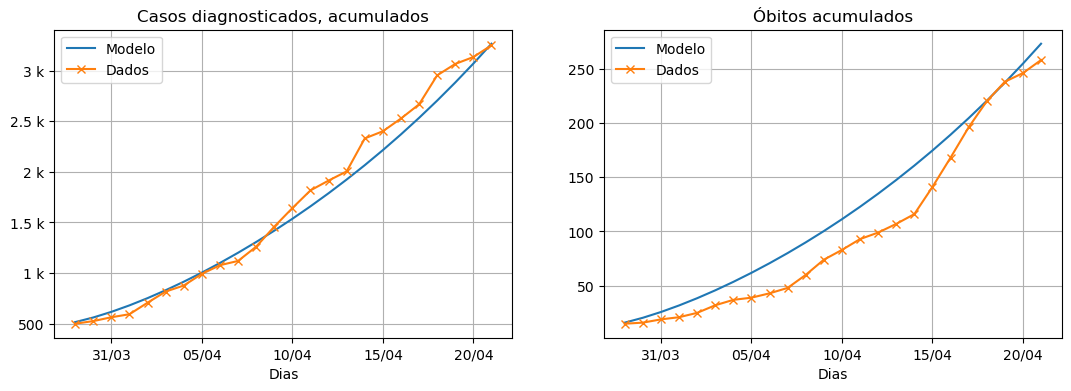

In [39]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [Rio_acc_d,Rio_acc_m]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Casos diagnosticados, acumulados")
axs[2].set_title("Óbitos acumulados")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_accum(serie, data,real_data = true, ax = ax,blur = 1.0, cor_dados = "x-")
end

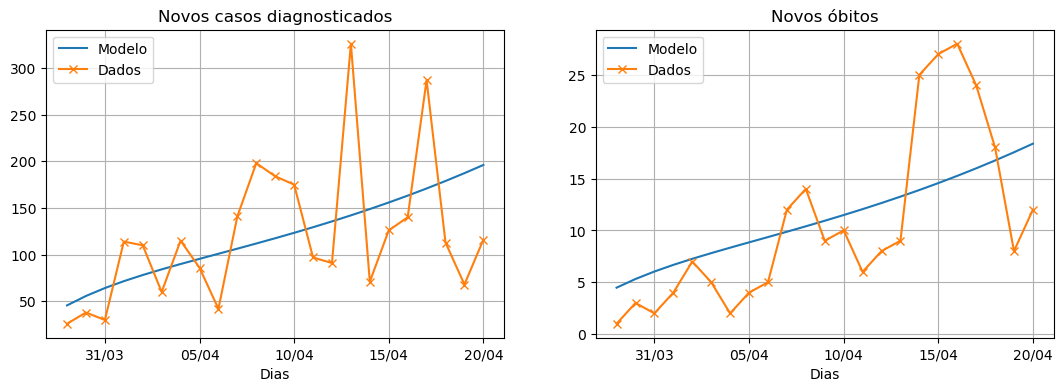

In [40]:
fig, axs = PyPlot.subplots(ncols=2, figsize=(13,4))
datas = [diagn_Rio,obitos_Rio]
series = [sol[9,:],sol[10,:]]
axs[1].set_title("Novos casos diagnosticados")
axs[2].set_title("Novos óbitos")
for (ax,serie,data) in zip(axs,series,datas)
    graph_py.plot_daily(serie, data,real_data = true, ax = ax)
end

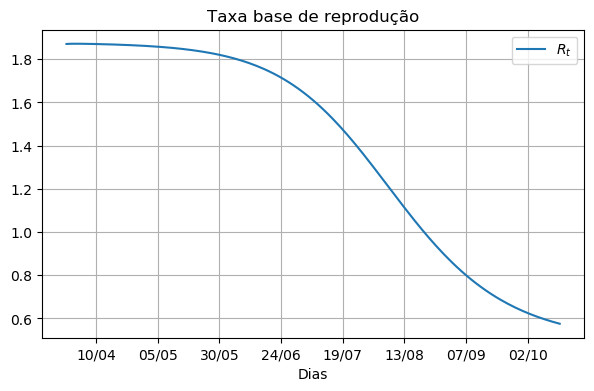

In [41]:
Ts = 0.0:1.0:200
CI_opt, p_opt = build_p_ci(res.minimizer)
sol = model(p_opt, CI_opt, Ts);
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
serie = Rt(sol,p_opt)
ax.set_title("Taxa base de reprodução")
graph_py.plot_accum(serie, Rio_acc_d,real_data = false, m_label = L"R_t", ax = ax,blur = 1.0, eng_fmt = false)

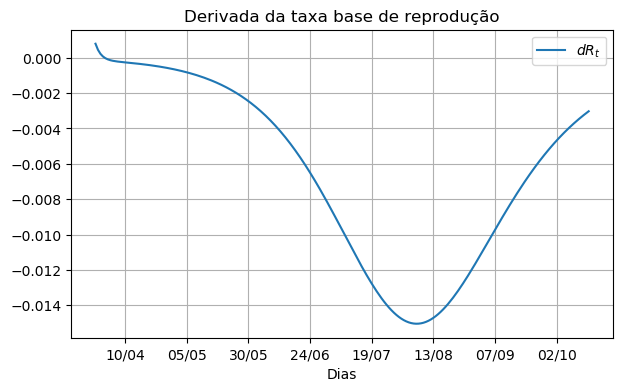

In [42]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
serie = dRt(sol,p_opt)
ax.set_title("Derivada da taxa base de reprodução")
graph_py.plot_accum(serie, Rio_acc_d,real_data = false, m_label = L"dR_t", ax = ax,blur = 1.0, eng_fmt = false)

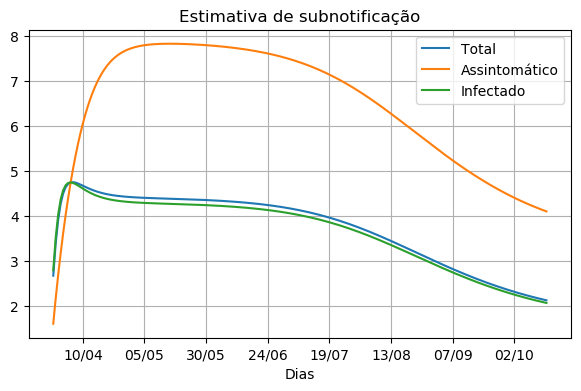

In [43]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(7,4))
series = [(sol[4,:].+sol[5,:])./(sol[6,:].+sol[7,:]),(sol[4,:])./(sol[6,:]),(sol[5,:])./(sol[7,:])]
m_labels = ["Total", "Assintomático", "Infectado"]
ax.set_title("Estimativa de subnotificação")
for (serie,label) in zip(series,m_labels)
    graph_py.plot_accum(serie, Rio_acc_d,real_data = false, m_label = label, ax = ax,blur = 1.0, eng_fmt = false)
end

## Variação dos parametros

In [44]:
min_arrs = build_params_variations(res);

In [45]:
possibilities, hr_poss = build_possibilities(min_arrs);

In [46]:
num_series(possibilities)

5775

In [47]:
@time series = prob_adjust(model, (a,b) -> 1, res -> likelihood(res, σ=1e7), param_range(possibilities));

  6.995500 seconds (5.25 M allocations: 610.335 MiB, 7.83% gc time)


In [48]:
idxs = build_random_samples(possibilities, n_samples = 2000);

In [49]:
ts = 40:5:90
xs, ws = build_series(series, idxs, ts);

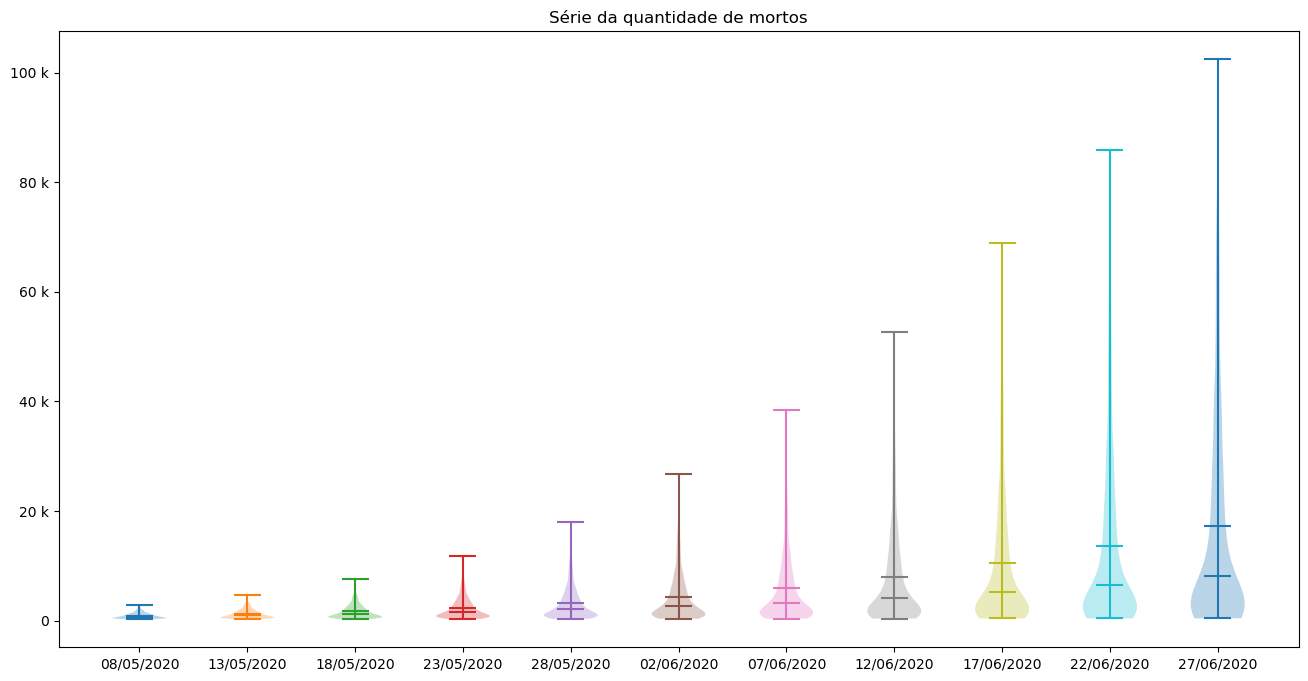

In [50]:
graph_py.graph_series(xs,ws,ts)

In [51]:
ts = 40:5:90
xs = [[Rt(series[j][1]["res"],p_opt)[t] for j in idxs] for t in ts]
ws = [[series[j][2] for j in idxs] for t in ts];

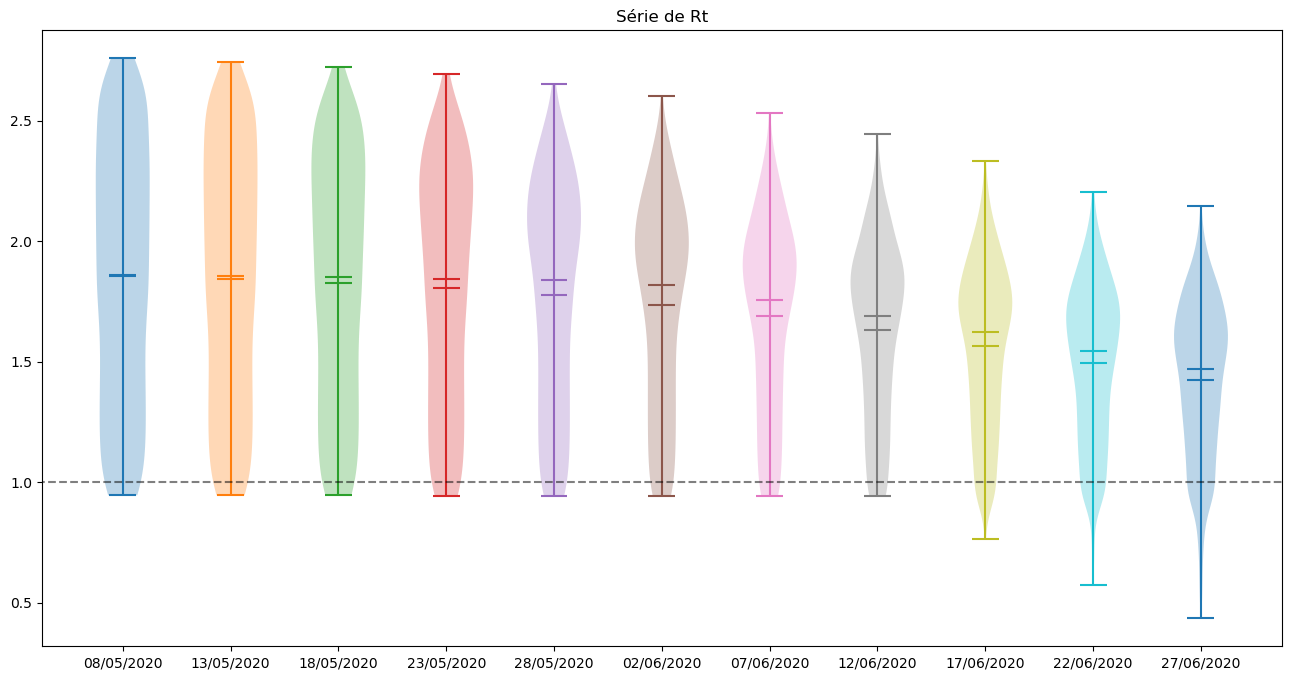

In [52]:
graph_py.graph_rt(xs,ws,ts)

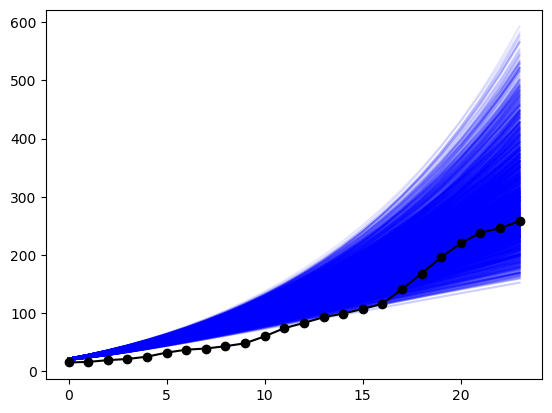

In [53]:
for x in [series[j][1]["res"][10,1:24] for j in idxs]
    PyPlot.plot(x, "b-", alpha=.1)
end
PyPlot.plot(Rio_acc_m, "ko-");

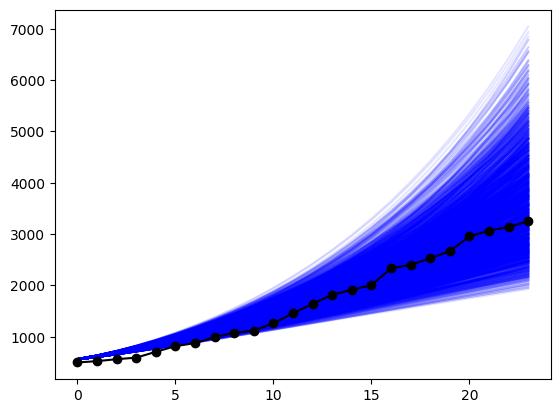

In [54]:
for x in [series[j][1]["res"][9,1:24] for j in idxs]
    PyPlot.plot(x, "b-", alpha=.1)
end
PyPlot.plot(Rio_acc_d, "ko-");

In [55]:
xs, ws = build_series_parameter(series, "quarentena", day = 40, possibilities, hr_poss, samples = 1000, serie = 10);

In [56]:
labels_quarentena = [string(Int(floor(x)))*"%" for x in hr_poss["quarentena"]];
x_label = "Porcentagem de quarentena";

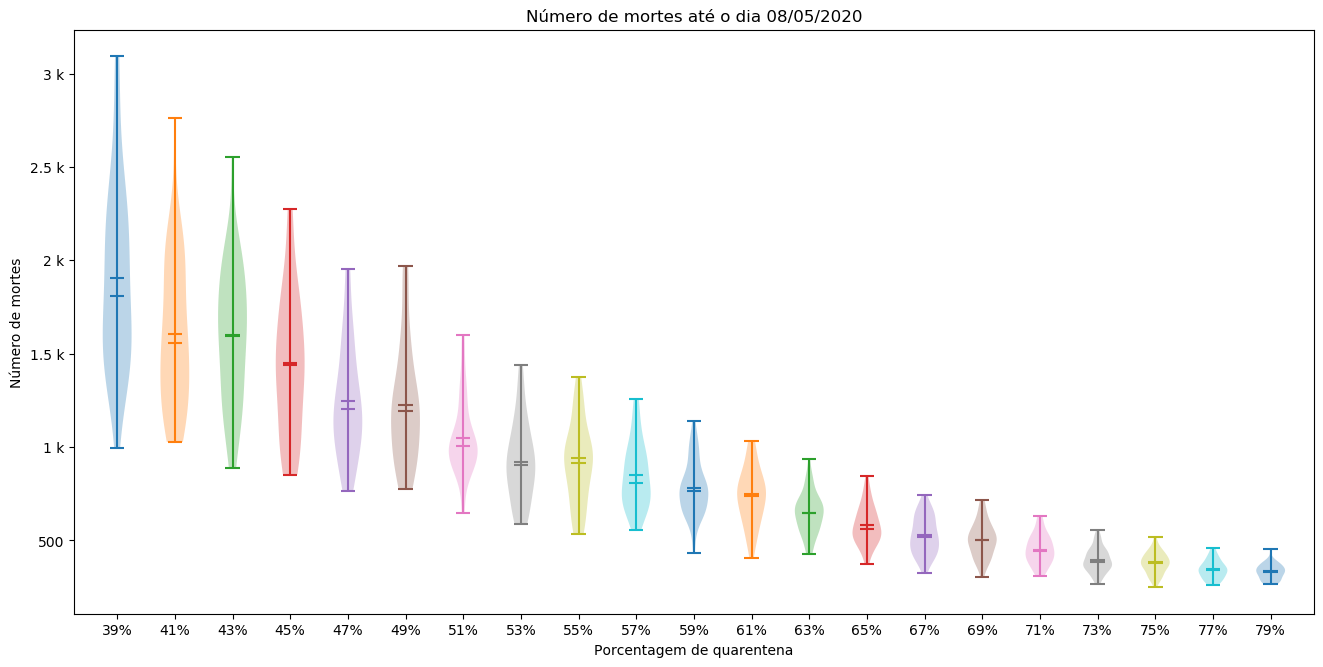

In [57]:
graph_py.graph_deaths(xs,ws,hr_poss["quarentena"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [58]:
xs, ws = build_series_parameter(series, "quarentena", day = 50, possibilities, hr_poss, samples = 1000);

In [59]:
labels_quarentena = [string(Int(floor(x)))*"%" for x in hr_poss["quarentena"]];
x_label = "Porcentagem de quarentena";

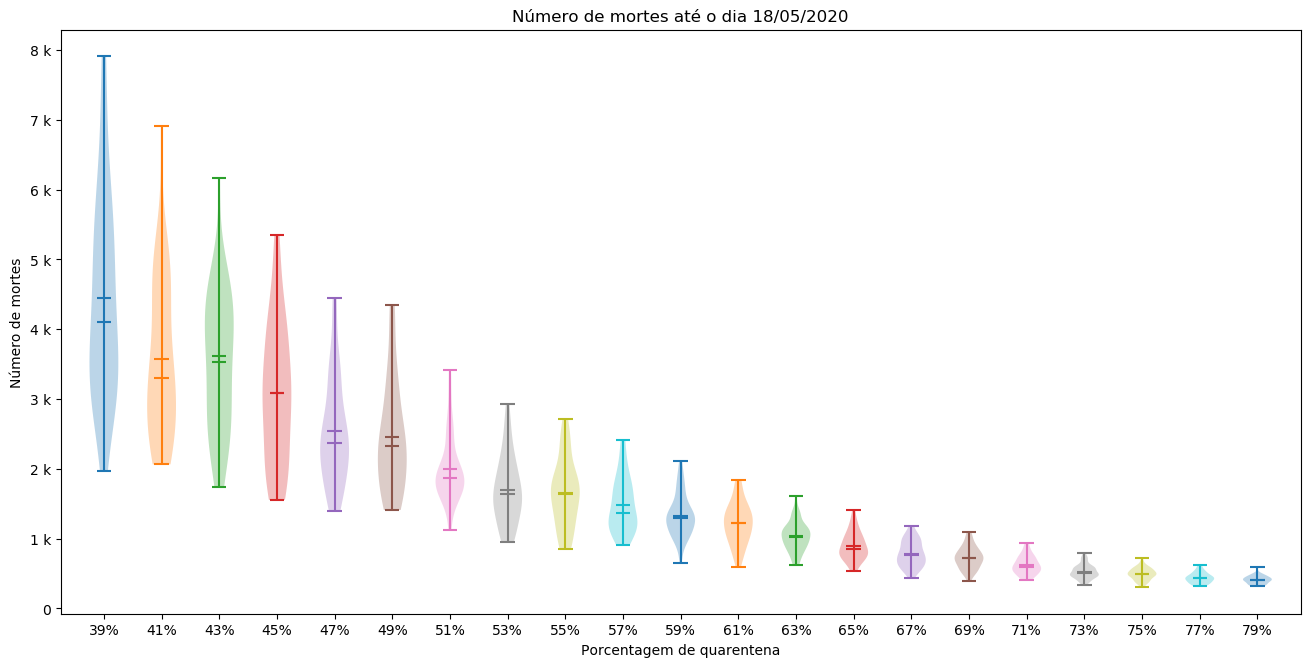

In [60]:
graph_py.graph_deaths(xs,ws,hr_poss["quarentena"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [61]:
xs, ws = build_series_parameter(series, "taxa_teste_a", day = 40, possibilities, hr_poss, samples = 1000);

In [62]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_a"]];
x_label = "Taxa de testagem de assintomáticos (dias)";

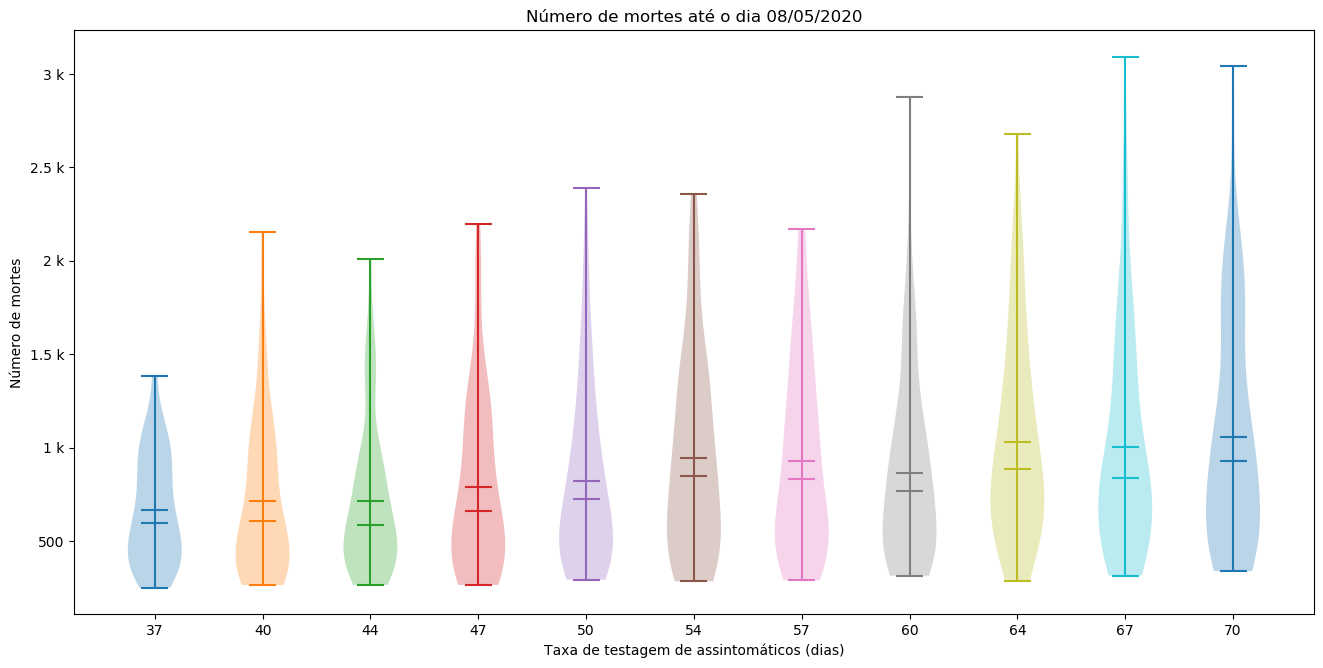

In [63]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_a"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [64]:
xs, ws = build_series_parameter(series, "taxa_teste_a", day = 50, possibilities, hr_poss, samples = 1000);

In [65]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_a"]];
x_label = "Taxa de testagem de assintomáticos (dias)";

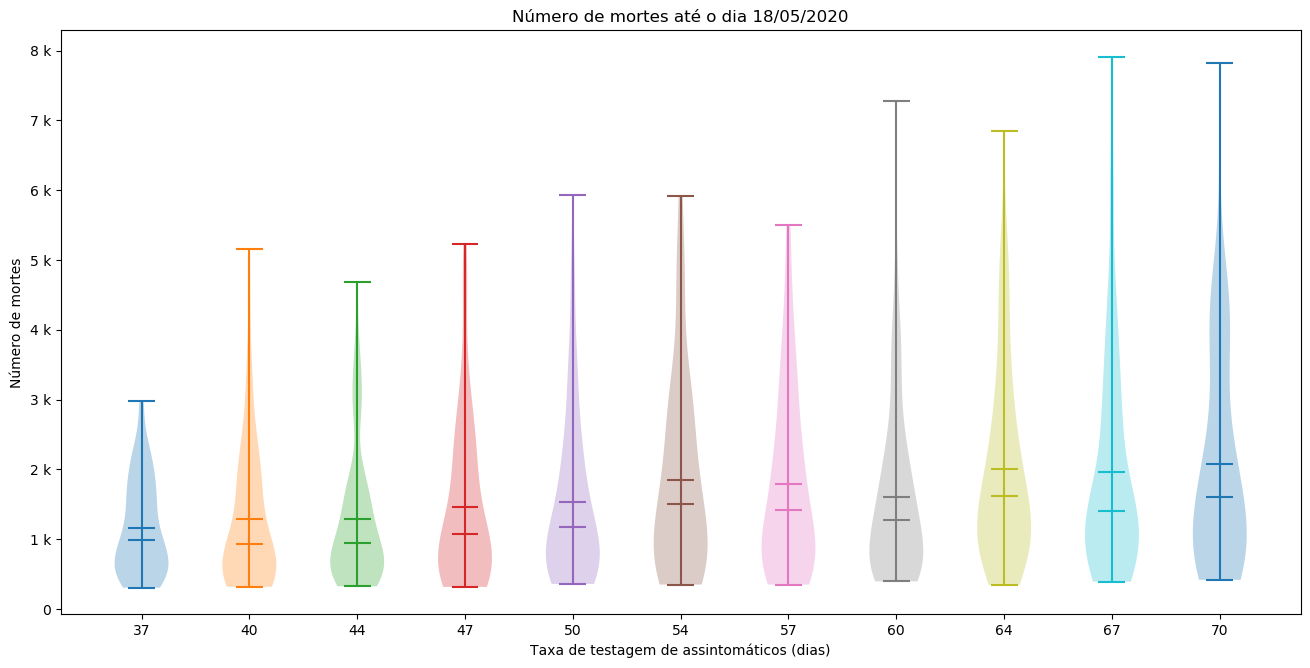

In [66]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_a"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [67]:
xs, ws = build_series_parameter(series, "taxa_teste_i", day = 40, possibilities, hr_poss, samples = 1000);

In [68]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_i"]];
x_label = "Taxa de testagem de infectados (dias)";

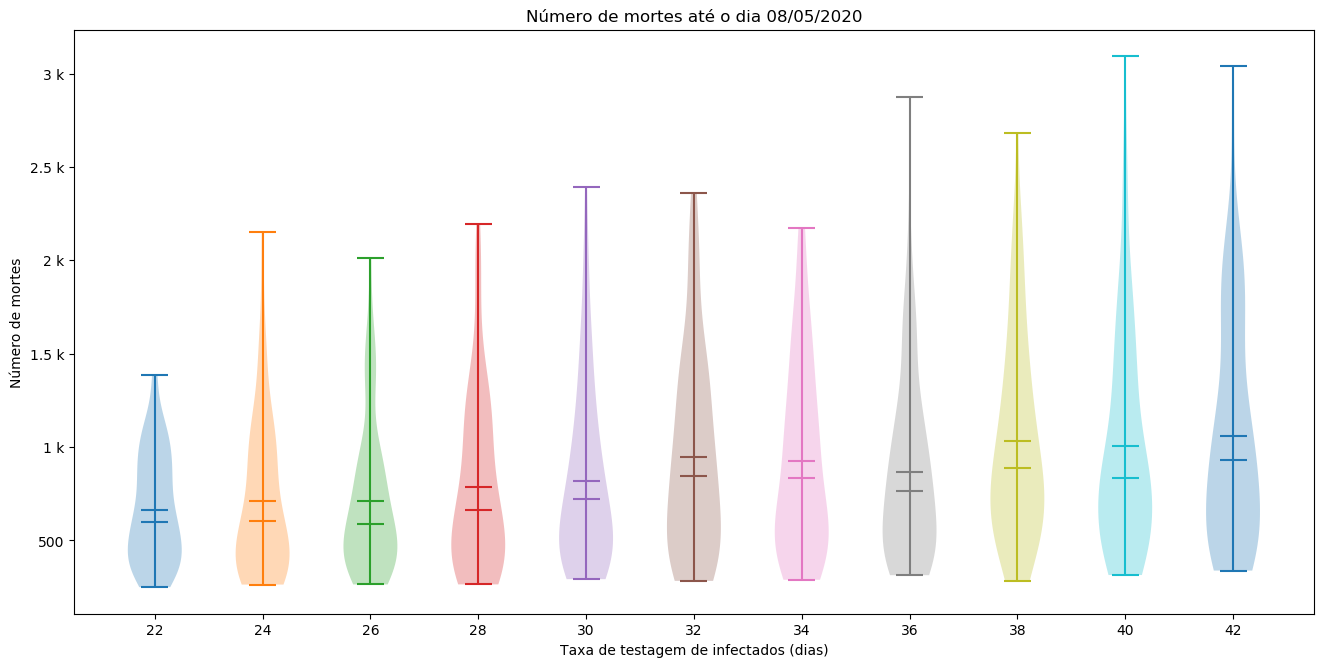

In [69]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_i"],day = 40, labels = labels_quarentena, x_label = x_label, reversed = false)

In [70]:
xs, ws = build_series_parameter(series, "taxa_teste_i", day = 50, possibilities, hr_poss, samples = 1000);

In [71]:
labels_quarentena = [Int(floor(x)) for x in hr_poss["taxa_teste_i"]];
x_label = "Taxa de testagem de infectados (dias)";

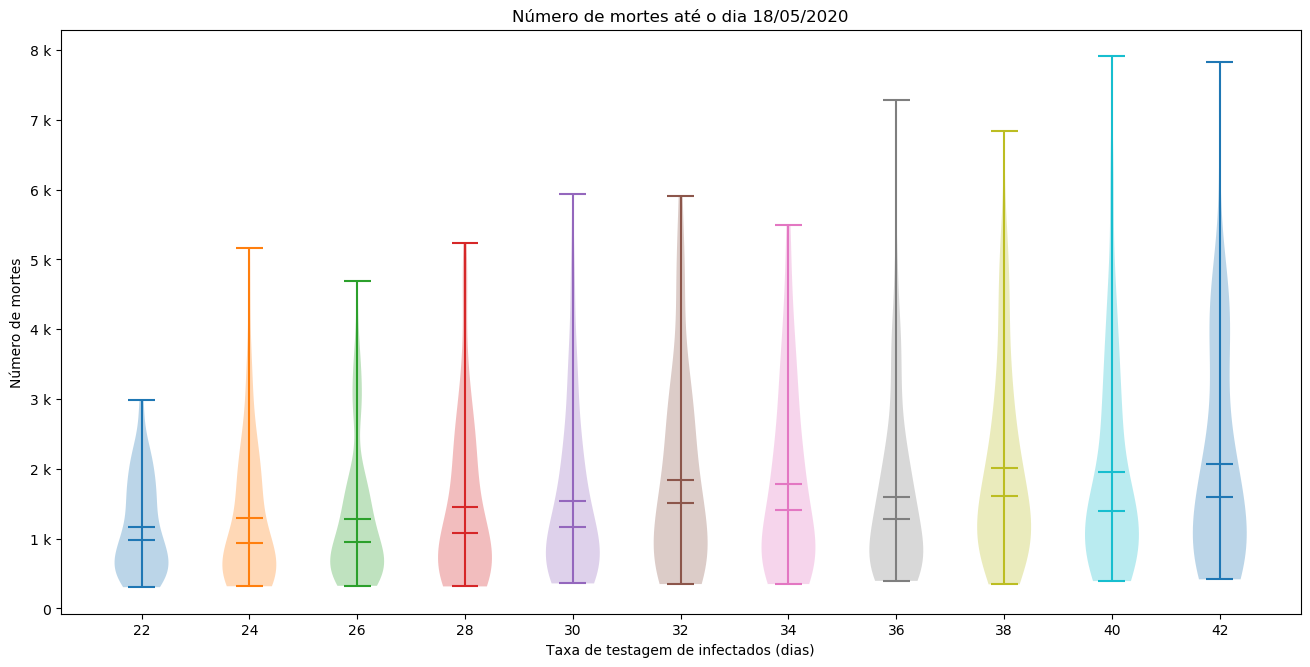

In [72]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_teste_i"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)

In [73]:
using Printf

In [74]:
xs, ws = build_series_parameter(series, "taxa_contagio", day = 50, possibilities, hr_poss, samples = 1000);

In [75]:
labels_quarentena = [@sprintf "%1.3f" x*CI_opt[1] for x in hr_poss["taxa_contagio"]];
x_label = "Taxa de contágio";

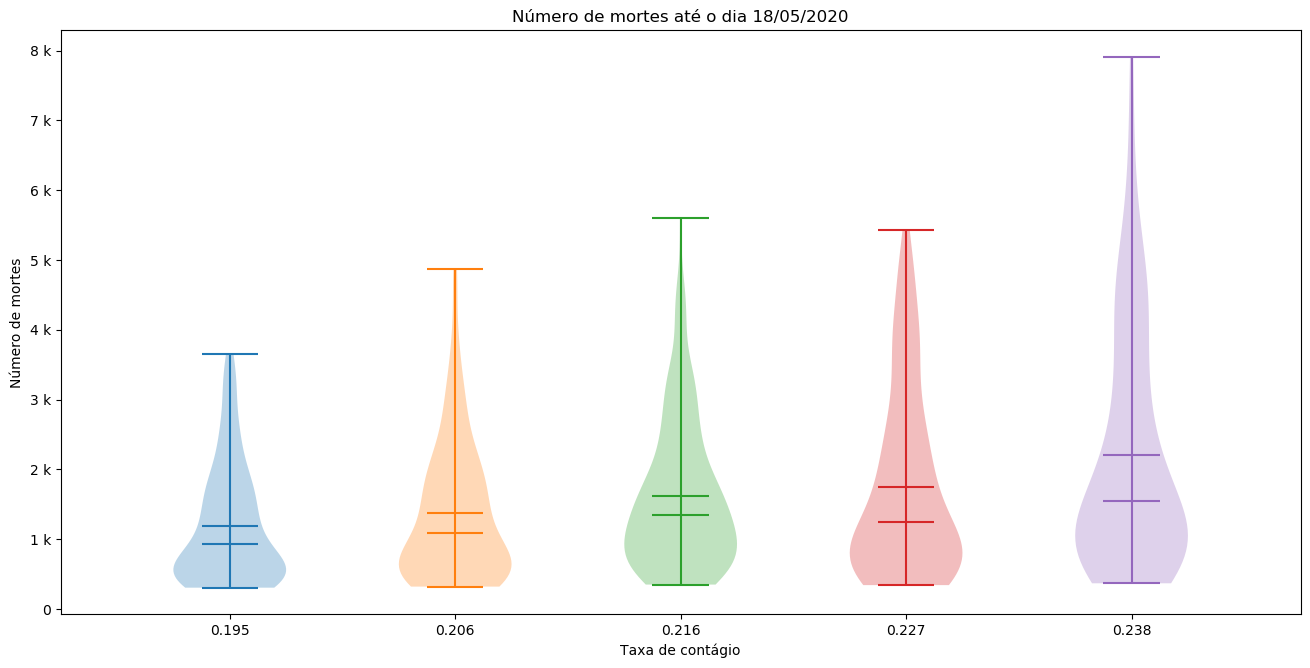

In [76]:
graph_py.graph_deaths(xs,ws,hr_poss["taxa_contagio"],day = 50, labels = labels_quarentena, x_label = x_label, reversed = false)